In [247]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_distribution
from qiskit_experiments.library import CorrelatedReadoutError
from qiskit.result import CorrelatedReadoutMitigator, ProbDistribution, marginal_distribution
from qiskit_experiments.framework import ExperimentData
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import BackendSampler

In [189]:
# Run only once to save the account
#IBMProvider.save_account(token='27fc81cc1143099c58b23780dbcb4725f2393a6016b59258fece524e61c35934cfac5f04ca7d1253750225e775c3cc1df4fd115bd23f4632961569d497648186')

In [190]:
provider = IBMProvider()
provider.active_account()
backend = provider.get_backend('ibm_sherbrooke')

sampler = BackendSampler(backend)

In [191]:
# Define a backend
#backend = AerSimulator.from_backend(FakePerth())

MITIGATION EXPERIMENT SETUP

In [228]:
# Set up the mitigation experiment
qubits = [0]
num_qubits = len(qubits)
exp1 = CorrelatedReadoutError(qubits)
exp2 = CorrelatedReadoutError(qubits)

# Print mitigation experiment circuits
for c in exp1.circuits():
    print(c)

for c in exp2.circuits():
    print(c)

         ░ ┌─┐
     q: ─░─┤M├
         ░ └╥┘
meas: 1/════╩═
            0 
        ┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0 
         ░ ┌─┐
     q: ─░─┤M├
         ░ └╥┘
meas: 1/════╩═
            0 
        ┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0 


MZI EXPERIMENT SETUP

In [193]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter
from qiskit.result import marginal_counts

In [194]:
# Define constants & parameters
pi = np.pi
phi_R = Parameter('phi_R') 
phi_S = Parameter('phi_S')

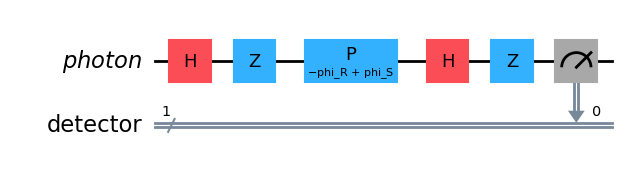

In [195]:
# Create a quantum register named "photon" and a classical bit
qr_photon = QuantumRegister(1, 'photon')
cr = ClassicalRegister(1, 'detector')

# Create a circuit with 1 qubit and 1 classical bit
qc = QuantumCircuit(qr_photon, cr)

# 1st BS; creates a superposition and a phase shift by π
qc.h(0)
qc.z(0)

# Phase shift by total of 2π due to the mirrors
# qc.p(pi*2,0)

# Phase shifts by (φ_S - φ_R) due to the lengths
qc.p(phi_S-phi_R,0)

# 2nd BS and a phase shift by π
qc.h(0)
qc.z(0)

# Measurement on qubit 0 (photon), projection on cbit 0 (detector)
qc.measure(0,0)

# Draw the circuit
qc.draw('mpl')

In [196]:
# Transpile the circuit
qc_trans = transpile(qc, backend)
print(qc_trans)

global phase: -phi_R/2 + phi_S/2 + 7π/2
                   ┌─────────┐┌────┐┌──────────┐┌────────────────────┐»
     photon_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-π/2) ├┤ Rz(-phi_R + phi_S) ├»
                   └─────────┘└────┘└──────────┘└────────────────────┘»
    ancilla_0 -> 1 ───────────────────────────────────────────────────»
                                                                      »
    ancilla_1 -> 2 ───────────────────────────────────────────────────»
                                                                      »
    ancilla_2 -> 3 ───────────────────────────────────────────────────»
                                                                      »
    ancilla_3 -> 4 ───────────────────────────────────────────────────»
                                                                      »
    ancilla_4 -> 5 ───────────────────────────────────────────────────»
                                                                      »
    ancilla_5 -> 6 ─────

COMBINE EXPERIMENTS

In [197]:
# Define # of shots for mitigation/qc runs
shots = 8192 # 2^13

In [198]:
# Assign phase shift params from 0 to 2π, construct a list of circuits
bound_qc = [] 
exp1_qc = []
exp2_qc = []

# Add the mitigation exp circuits in the list prior to the MZI circuits
exp1_qc.append(exp1.circuits()[0])
exp1_qc.append(exp1.circuits()[1])

# Add the MZI circuits in the list
for i in range(33):
    param_values = {phi_S: (pi/16)*i, phi_R: 0}
    bound_qc.append(qc_trans.assign_parameters(param_values))

# Add the mitigation exp circuits in the list after the MZI circuits
exp2_qc.append(exp2.circuits()[0])
exp2_qc.append(exp2.circuits()[1])

all_qc = exp1_qc + bound_qc + exp2_qc
print(len(all_qc)) # Should be 37 in total = 2 prior mitigation circ + 33 MZI circ + 2 post mitigation circ

37


RUN THE EXPERIMENT

In [256]:
job = sampler.run(all_qc, shots=shots)
print(job.job_id())

979268eb-a900-45e4-94b6-b1f08a8ca780


RETRIEVE THE JOB

In [323]:
# Define job id
job_id = 'cszhtz3cqfh00089f250'
job = QiskitRuntimeService().job(job_id)
result = job.result()

In [325]:
# Get Mitigation experitment results
exp1_results = [result.get_counts()[i] for i in range(2)]
exp2_results = [result.get_counts()[35+i] for i in range(2)]

# Takes in mitigation experiment results and contructs a assignment matrix
# Returns an assignment matrix
def generate_assignment_matrix(exp_results):
    state_labels = ['0','1']
    assignment_matrix = np.zeros((2**num_qubits, 2**num_qubits))
    for state_idx, state in enumerate(state_labels):
        counts = exp_results[state_idx]
        for measured_state, count in counts.items():
            measured_idx = state_labels.index(measured_state)
            assignment_matrix[measured_idx, state_idx] = count / shots
    return assignment_matrix

# Construct mitigator objects
mitigator1 = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp1_results))
mitigator2 = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp2_results))

In [326]:
# Get unmitigated counts
unmitigated_counts = [result.get_counts()[2+i] for i in range(33)]

DEFINE TWO MITIGATION METHODS

In [327]:
# Define empty arrays to store unmitigated probabilities, mitigated probabilities, and mitigated counts
unmitigated_probs = []
mitigated_quasi_probs = []
mitigated_probs = []
mitigated_counts = []

# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator)  
# Calculates unmitigated probailities, mitigated quasi-probabilities
# Calculates mitigated probabilities with quasi-probabilites on L2 norm
# Calculates mitigated counts
def mitigation_method_1(mitigator):
    unmitigated_probs.clear()
    mitigated_quasi_probs.clear()
    mitigated_probs.clear()
    mitigated_counts.clear()
    for i in range(33):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        mitigated_quasi_probs.append(mitigator.quasi_probabilities(unmitigated_counts[i]))
        mitigated_probs.append(mitigated_quasi_probs[i].nearest_probability_distribution().binary_probabilities())
        mitigated_counts.append({label: round(prob*shots) for (label, prob) in mitigated_probs[i].items()})

# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator) 
# Calculates unmitigated probailities
# Calculates mitigated quasi-counts by multiplication with inv confusion matrix
# Calculates mitigated counts by throwing away negative counts
# Calculates mitigated probabilites by re-normalizing with new shots #
def mitigation_method_2(mitigator):
    unmitigated_probs.clear()
    mitigated_quasi_probs.clear() 
    mitigated_probs.clear() 
    mitigated_counts.clear() 
    for i in range(33):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        # Creates a column vector of the counts
        vec_count = np.array([unmitigated_counts[i]['0'], unmitigated_counts[i]['1']])[:, np.newaxis]
        mitigated_quasi_count = np.dot(mitigator.mitigation_matrix(),vec_count)
        # if either count is negative, set it to 0 and calculate the total count
        if mitigated_quasi_count[0] < 0:
            mitigated_quasi_count[0] = 0
        if mitigated_quasi_count[1] < 0:
            mitigated_quasi_count[1] = 0
        total_count = mitigated_quasi_count[0] + mitigated_quasi_count[1]
        # Define dictionaries
        dict_count = {
            '0': mitigated_quasi_count[0].item(),
            '1': mitigated_quasi_count[1].item()
        }
        dict_prob = {
            '0': (mitigated_quasi_count[0]/total_count).item(),
            '1': (mitigated_quasi_count[1]/total_count).item()
        }
        mitigated_counts.append(dict_count)
        mitigated_probs.append(dict_prob)    

PRINT RESULT

Unmitigated Counts: 
{'1': 8117, '0': 75}
Mitigated Counts: 
{'0': 12.172362555720643, '1': 8179.827637444279}

Unmitigated Prob: 
{'1': 0.9908447265625, '0': 0.0091552734375}
Mitigated Prob: 
{'0': 0.0014858841010401175, '1': 0.9985141158989599}


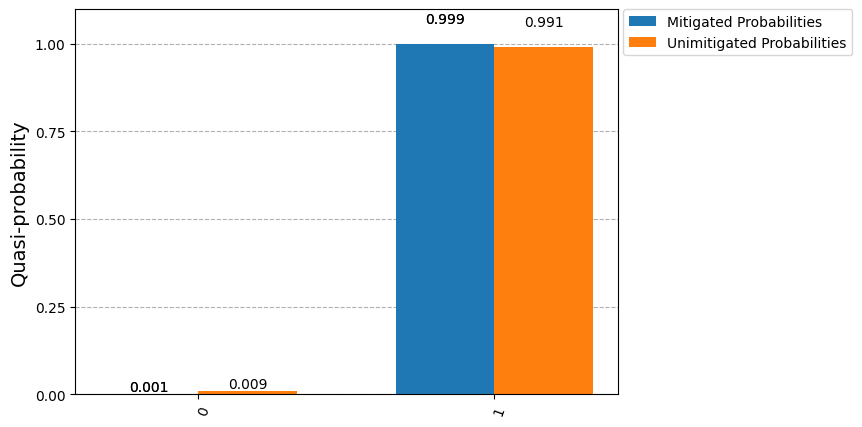

In [336]:
# Pick a mitigation_method (method_1 = least_squares, method_2 = throwaway zeros)
# Parameter: 0 for pre-mitigator, 1 for post-mitigator
mitigation_method_2(mitigator1)

# Index of a circuit [0~32: 0=0π, 16=π, 32=2π]
i = 0

# Print unmitigated & mitigated counts and plot 
print("Unmitigated Counts: ")
print(unmitigated_counts[i]) 
print("Mitigated Counts: ")
print(mitigated_counts[i])
print("")
print("Unmitigated Prob: ")
print(unmitigated_probs[i])
print("Mitigated Prob: ")
print(mitigated_probs[i])

legend = ['Mitigated Probabilities','Unimitigated Probabilities']
plot_distribution([mitigated_probs[i], unmitigated_probs[i]], legend=legend)